In [14]:
# Libraries
import pandas as pd
from pandas import DataFrame
from nltk import edit_distance
from fuzzywuzzy import fuzz
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
import numpy as np

In [15]:
from nltk.corpus import stopwords

In [16]:
# Get data
# df = pd.read_csv("cust10k.csv", delimiter="|")
file = "./affiliationstrings/affiliationstrings_ids.csv"
df = pd.read_csv(file, index_col=0)
df.columns=["entityname"]

In [17]:
df.head()

,entityname
id1,
7927,", IBM Almaden Research Center, 650 Harry Road,..."
7930,", IIT Bombay"
7987,", University of California, San Diego, USA"
5613,"28msec Inc., Zurich, Switzerland"
9530,"28msec, Inc."


In [18]:
df.loc[8544]

entityname    Department of Computer Engineering, Kyungpook ...
Name: 8544, dtype: object

In [19]:
df.shape

(2260, 1)

In [20]:
df.columns = ["entityname_original"]

In [21]:
df.head()

,entityname_original
id1,
7927,", IBM Almaden Research Center, 650 Harry Road,..."
7930,", IIT Bombay"
7987,", University of California, San Diego, USA"
5613,"28msec Inc., Zurich, Switzerland"
9530,"28msec, Inc."


In [22]:
# Stopword removal and lowercase conversion
# stop = stopwords.words("english")
# df["entityname"] = df["entityname_original"].apply(lambda x: " ".join(word for word in x.lower().split(" ") if word not in stop))
df["entityname"] = df["entityname_original"]

In [23]:
df.sample(5)

,entityname_original,entityname
id1,,
2793,"Infobright Inc., Poland","Infobright Inc., Poland"
8732,"Department of Electrical Engineering, National...","Department of Electrical Engineering, National..."
3865,"IBM Almaden Research Center, San Jose, CA, USA","IBM Almaden Research Center, San Jose, CA, USA"
8148,"Laboratoire de Recherche en Informatique, Univ...","Laboratoire de Recherche en Informatique, Univ..."
725,Department of Computer Science and Engineering...,Department of Computer Science and Engineering...


In [24]:
def setup():
    # Add a column to store grouping
    df["GroupA"] = None
    df["GroupB"] = None
    df["GroupC"] = None
    df["GroupD"] = None
    df["GroupE"] = None
    df["GroupF"] = None
    df["GroupG"] = None
    df["GroupH"] = None
    df["GroupI"] = None
    df["GroupJ"] = None
    df["GroupA_id1"] = None
    df["GroupB_id1"] = None
    df["GroupC_id1"] = None
    df["GroupD_id1"] = None
    df["GroupE_id1"] = None
    df["GroupF_id1"] = None
    df["GroupG_id1"] = None
    df["GroupH_id1"] = None
    df["GroupI_id1"] = None
    df["GroupJ_id1"] = None
    df["GroupA_score"] = None
    df["GroupB_score"] = None
    df["GroupC_score"] = None
    df["GroupD_score"] = None
    df["GroupE_score"] = None
    df["GroupF_score"] = None
    df["GroupG_score"] = None
    df["GroupH_score"] = None
    df["GroupI_score"] = None
    df["GroupJ_score"] = None

In [25]:
setup() # RUN THIS FIRST!!!

In [26]:
groups = ["GroupA", "GroupB", "GroupC", "GroupD", "GroupE", "GroupF", "GroupG", "GroupH", "GroupI", "GroupJ"]

for g in groups:
    print(f"Starting: {g}")
    print("=" * 72)
    initial = datetime.now()
    df = df.sample(frac=1)
    # indices of names for looping
    list_idx = [idx for idx in df.index]
    
    # Loop through names
#     num_records = 100 # restrict for debug
#     for idx in list_idx[:num_records]: # restrict for debug
    
    for idx in list_idx:
#         print("-" * 72)
        current_name = df.loc[idx]['entityname']
#         print(f"idx:{idx} name to compare: {current_name}")
        
    
        if df.loc[idx][g] is None:
            idx_to_compare = list_idx[list_idx.index(idx)+1:]
            for i in idx_to_compare:
                if df.loc[i][g] is None:
                    compare_name = df.loc[i]["entityname"]
                    similarity_score = fuzz.ratio(current_name, compare_name)
                    if similarity_score > 88:
    #                     print(f"Similarity score:{similarity_score}")
                        df.loc[df.index == i, g] = current_name
                        df.loc[df.index == i, g+"_score"] = similarity_score
                        df.loc[df.index == i, g+"_id1"] = idx
#         else:
#             print(f"{current_name} already matched. Skipping.")
    
    
    
    final = datetime.now()
    total_time = final - initial
    print("=" * 72)
    print(f"Group {g} total time: {total_time}")

print("Saving groups...")
df.to_csv("edit_dist_dedup_groups.csv")
print("Save complete!")

Starting: GroupA
Group GroupA total time: 0:07:48.484438
Starting: GroupB
Group GroupB total time: 0:07:54.737807
Starting: GroupC
Group GroupC total time: 0:07:50.664513
Starting: GroupD
Group GroupD total time: 0:07:52.871131
Starting: GroupE
Group GroupE total time: 0:07:47.075646
Starting: GroupF
Group GroupF total time: 0:07:53.890339
Starting: GroupG
Group GroupG total time: 0:07:51.738584
Starting: GroupH
Group GroupH total time: 0:07:48.358386
Starting: GroupI
Group GroupI total time: 0:07:52.885855
Starting: GroupJ
Group GroupJ total time: 0:07:55.747452
Saving groups...
Save complete!


In [27]:
# group = "GroupA"
# print(f"Number of matches: {df[group].value_counts().sum()}")
# print(f"Number of groups: {len(df[group].unique())}")
# df[group].value_counts()[:10]

In [28]:
# df.loc[df["entityname"].str.contains("AT&T")].head()

Remove duplicate permutations of tuples:

https://stackoverflow.com/questions/15352995/removing-permutations-from-a-list-of-tuples

In [29]:
matches_temp = list(set(list(zip(df["GroupA_id1"].index, df["GroupA_id1"].values)) + \
        list(zip(df["GroupB_id1"].index, df["GroupB_id1"].values)) + \
        list(zip(df["GroupC_id1"].index, df["GroupC_id1"].values)) + \
        list(zip(df["GroupD_id1"].index, df["GroupD_id1"].values)) + \
        list(zip(df["GroupE_id1"].index, df["GroupE_id1"].values)) + \
        list(zip(df["GroupF_id1"].index, df["GroupF_id1"].values)) + \
        list(zip(df["GroupG_id1"].index, df["GroupG_id1"].values)) + \
        list(zip(df["GroupH_id1"].index, df["GroupH_id1"].values)) + \
        list(zip(df["GroupI_id1"].index, df["GroupI_id1"].values)) + \
        list(zip(df["GroupJ_id1"].index, df["GroupJ_id1"].values))))

matches = []
for m in matches_temp:
    if m[0] is not None and m[1] is not None:
        matches.append(m)

# Remove permutation duplicates
matches = list(set(tuple(sorted(t)) for t in matches))

In [30]:
len(matches)

1324

In [31]:
matches[:10]

[(2268, 7422),
 (130, 8584),
 (135, 9779),
 (48, 8992),
 (397, 467),
 (4266, 7287),
 (6064, 6278),
 (1974, 9593),
 (1522, 8686),
 (1837, 2065)]

In [32]:
df_matches = pd.DataFrame(matches)
df_matches.columns = ["entityid1", "entityid2"]
# df_matches.set_index("entityid1", inplace=True)
df_matches["match_string"] = df_matches.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_matches.head()

,entityid1,entityid2,match_string
0,2268,7422,2268|7422
1,130,8584,130|8584
2,135,9779,135|9779
3,48,8992,48|8992
4,397,467,397|467


In [33]:
# Get ground truth
file = "./affiliationstrings/affiliationstrings_mapping.csv"
df_truth = pd.read_csv(file, index_col=0, header=None, names=["entityid1", "entityid2"])

In [34]:
truth_tuples = list(df_truth.reset_index().to_records(index=False))
truth_unique = list(set(tuple(sorted(t)) for t in truth_tuples))
truth_unique[:10]

[(3460, 6963),
 (1808, 4095),
 (3265, 9562),
 (2551, 5771),
 (6605, 7876),
 (3842, 9044),
 (6150, 6549),
 (4208, 9532),
 (9136, 9376),
 (2927, 8872)]

In [35]:
len(truth_unique)

16408

In [36]:
df_truthunique = pd.DataFrame(truth_unique)
df_truthunique.columns = ["entityid1", "entityid2"]
# df_truthunique.set_index("entityid1", inplace=True)
df_truthunique["match_string"] = df_truthunique.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_truthunique.head()

,entityid1,entityid2,match_string
0,3460,6963,3460|6963
1,1808,4095,1808|4095
2,3265,9562,3265|9562
3,2551,5771,2551|5771
4,6605,7876,6605|7876


In [37]:
matches_list = list(df_matches["match_string"])
truth_list = list(df_truthunique["match_string"])

In [38]:
len(matches_list)

1324

In [39]:
good_matches = []
for m in matches_list:
    if m in truth_list:
        good_matches.append("Good match")
    else:
        good_matches.append("Bad match")

In [40]:
len(good_matches)

1324

In [41]:
df_matches["GoodBad"] = good_matches

In [42]:
df_matches.head()

,entityid1,entityid2,match_string,GoodBad
0,2268,7422,2268|7422,Good match
1,130,8584,130|8584,Good match
2,135,9779,135|9779,Bad match
3,48,8992,48|8992,Bad match
4,397,467,397|467,Good match


In [43]:
df_matches["GoodBad"].value_counts()

Good match    1201
Bad match      123
Name: GoodBad, dtype: int64

In [44]:
found_truth = []
for m in truth_list:
    if m in matches_list:
        found_truth.append("Found")
    else:
        found_truth.append("Not found")

In [45]:
len(found_truth)

16408

In [46]:
df_truthunique["Found"] = found_truth

In [47]:
df_truthunique.head()

,entityid1,entityid2,match_string,Found
0,3460,6963,3460|6963,Not found
1,1808,4095,1808|4095,Not found
2,3265,9562,3265|9562,Not found
3,2551,5771,2551|5771,Not found
4,6605,7876,6605|7876,Not found


In [48]:
df_truthunique["Found"].value_counts()

Not found    15207
Found         1201
Name: Found, dtype: int64

### Use NetworkX to generate connected components

In [49]:
import networkx as nx

In [50]:
G = nx.Graph()
G.add_edges_from(matches)

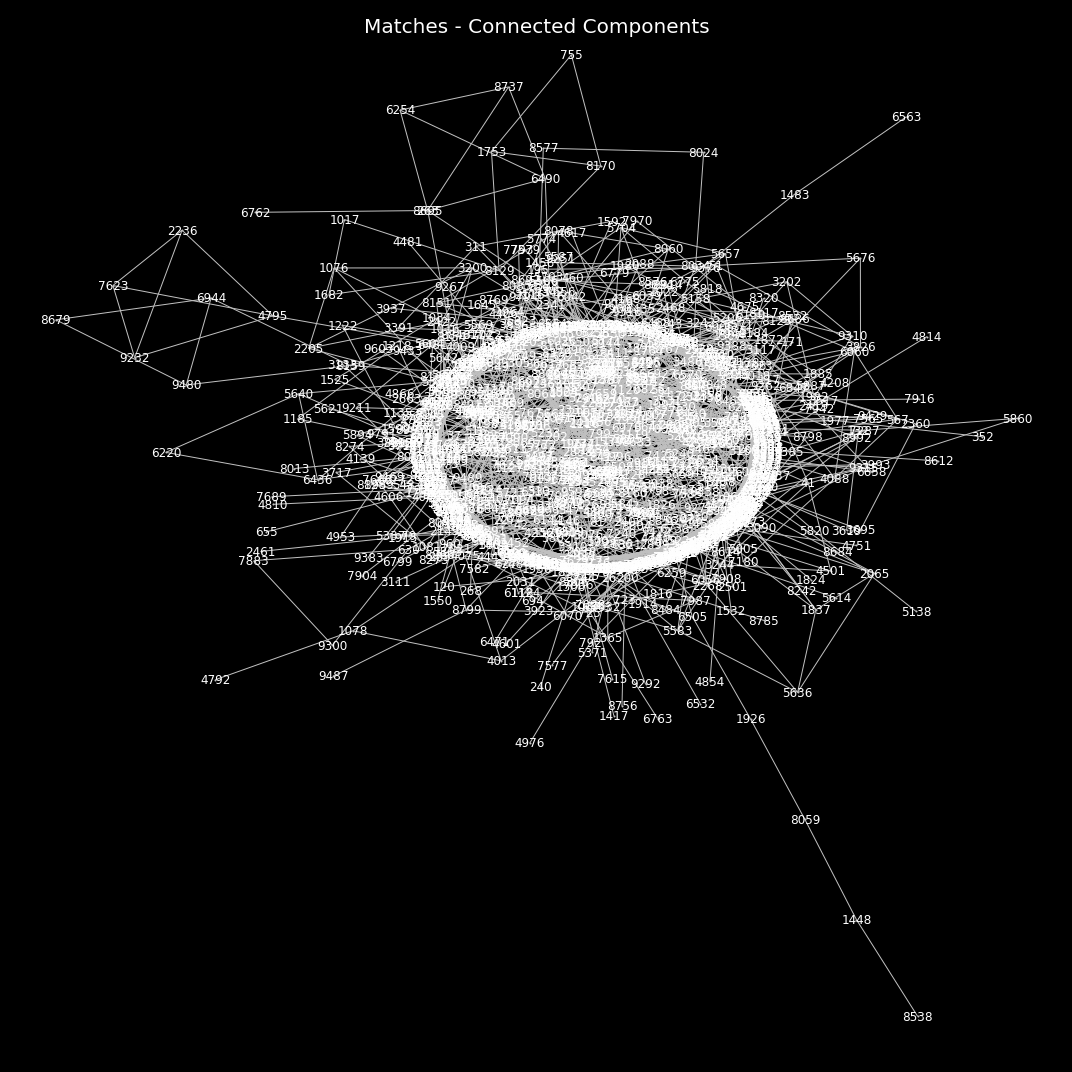

In [51]:
fig = plt.figure(figsize=(15,15), facecolor="black")
ax = nx.draw_networkx(G,
                      with_labels=True,
                      node_size=1,
                      alpha=1,
                      pos=nx.kamada_kawai_layout(G),
#                       pos=nx.spring_layout(G),
                      edge_color="silver",
                      node_color="silver",
                     font_size=12,
                     font_color="white")
plt.axis("off")
plt.tight_layout()
plt.suptitle("Matches - Connected Components", fontsize=20, color="white")
plt.show()

In [52]:
# Print pair of entities
print(df.loc[41]["entityname"])
print(df.loc[51]["entityname"])

Hong Kong University of Science and Technology, China
The Hong Kong University of Science and Technology, Hong Kong, China


In [53]:
# Current score for a pair that was not found
fuzz.ratio("Hong Kong University of Science and Technology, China",
          "The Hong Kong University of Science and Technology, Hong Kong, China")

88

In [54]:
# Same pair as above but with stopword removal
fuzz.ratio("Hong Kong University Science Technology China",
          "Hong Kong University Science Technology Hong Kong China")

90

In [55]:
# Connected component subgraphs
cc_subgraphs = list(nx.connected_components(G))

In [56]:
len(cc_subgraphs)

325

In [57]:
# list(cc_subgraphs[1])

In [58]:
# Generate all matching pairs based on connected components
match_pairs = []
for subgraph in cc_subgraphs:
    cc = list(subgraph)
    cc.sort()
    combos = list(itertools.combinations(cc, 2))
    for c in combos:
        match_pairs.append(c)
#     print(combos)
#     print("-"*72)

In [59]:
len(match_pairs)

2793

In [60]:
match_pairs[:10]

[(263, 363),
 (263, 682),
 (263, 1068),
 (263, 1342),
 (263, 1837),
 (263, 2038),
 (263, 2065),
 (263, 2268),
 (263, 2330),
 (263, 2573)]

In [61]:
df_ccmatches = pd.DataFrame(match_pairs)
df_ccmatches.columns = ["entityid1", "entityid2"]
df_ccmatches["match_string"] = df_ccmatches.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_ccmatches.head()

,entityid1,entityid2,match_string
0,263,363,263|363
1,263,682,263|682
2,263,1068,263|1068
3,263,1342,263|1342
4,263,1837,263|1837


In [62]:
df_ccmatches.shape

(2793, 3)

In [63]:
ccmatches_list = list(df_ccmatches["match_string"])

In [64]:
good_ccmatches = []
for m in ccmatches_list:
    if m in truth_list:
        good_ccmatches.append("Good match")
    else:
        good_ccmatches.append("Bad match")

In [65]:
df_ccmatches["GoodBad"] = good_ccmatches

In [66]:
df_ccmatches.head()

,entityid1,entityid2,match_string,GoodBad
0,263,363,263|363,Bad match
1,263,682,263|682,Good match
2,263,1068,263|1068,Good match
3,263,1342,263|1342,Good match
4,263,1837,263|1837,Bad match


In [67]:
df_ccmatches["GoodBad"].value_counts()

Good match    2127
Bad match      666
Name: GoodBad, dtype: int64

In [68]:
found_good_matches = list(df_ccmatches.loc[df_ccmatches["GoodBad"]=="Good match"]["match_string"])

In [69]:
truth_not_found = []
for t in truth_list:
    if t not in found_good_matches:
        truth_not_found.append(t)
print(f"Number of truths not found: {len(truth_not_found)}")

Number of truths not found: 14281


In [70]:
found_good_matches[:10]

['263|682',
 '263|1068',
 '263|1342',
 '263|5636',
 '263|6254',
 '263|6490',
 '263|6762',
 '263|8737',
 '363|1837',
 '363|2038']

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 75 (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     221405</li>
        <li>Good match     7261</li>
        <li>Good/Bad     0.03</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 80  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     15725</li>
        <li>Good match     4719</li>
        <li>Good/Bad     0.3</li>
    </ul>
</div>


<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 85  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     2253</li>
        <li>Good match     2706</li>
        <li>Good/Bad     1.20</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 88  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     666</li>
        <li>Good match     2127</li>
        <li>Good/Bad     3.19</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 90  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     165</li>
        <li>Good match     1339</li>
        <li>Good/Bad     8.12</li>
    </ul>
</div>

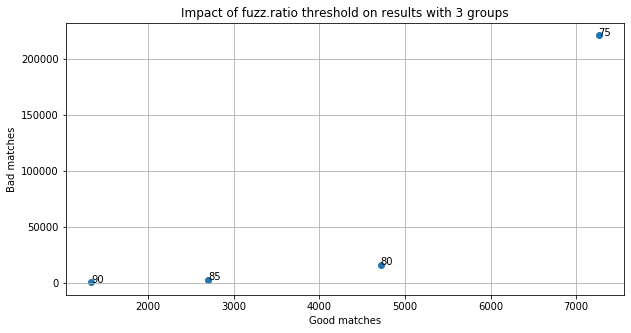

In [71]:
labels=[75,80,85,90]
x=[7261,4719,2706,1339]
y=[221405,15725,2253,165]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x=x, y=y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

# plt.axis("equal")
# plt.xlim(left=0, right=max(y))
plt.title("Impact of fuzz.ratio threshold on results with 3 groups")
plt.xlabel("Good matches")
plt.ylabel("Bad matches")
plt.grid()

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 90  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     218</li>
        <li>Good match     1608</li>
        <li>Good/Bad     7.38</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 90  (with stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     227</li>
        <li>Good match     1499</li>
        <li>Good/Bad     6.60</li>
    </ul>
</div>